## Test Random Forest tuned 

In [55]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report




In [56]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [57]:
target = pd.read_csv("../data/processed/target_df.csv", index_col = 0)["target"]

In [58]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [59]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

## Random Forest with data from MC simulation and some addtional features

In [60]:
new_df = pd.concat((ml_df[["UNDERLYING_LAST", "STRIKE", "C_LAST", "C_BID", "C_ASK", "C_IV", "C_VOLUME", "diff"]],wk_df.drop(["last_quote", "strike"], axis=1) ), axis=1)

In [61]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"]-new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"]-new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"],2)
new_df["exp_profit"] = new_df["exp_price"]-(new_df["STRIKE"]+new_df["C_LAST"])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(new_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=False)

In [63]:
rf_params = {'n_estimators': 73,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 18,
 'criterion': 'gini',
 'bootstrap': False,
 'n_jobs' : 4, 
 'verbose':1,
 'random_state':1968}

In [64]:
pipe = Pipeline([('imputer', SimpleImputer(strategy="constant", fill_value=0.0)),  ('rf', RandomForestClassifier(**rf_params))])

In [65]:
# Fit the random search model
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  73 out of  73 | elapsed:    0.3s finished


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 RandomForestClassifier(bootstrap=False, max_depth=18,
                                        max_features='log2', min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=73,
                                        n_jobs=4, random_state=1968,
                                        verbose=1))])

In [66]:
predictions = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  73 out of  73 | elapsed:    0.0s finished


In [67]:
pipe.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  73 out of  73 | elapsed:    0.0s finished


0.4581673306772908

In [68]:
ml_df.head()

,QUOTE_DATE,EXPIRE_DATE,UNDERLYING_LAST,STRIKE,C_LAST,C_BID,C_ASK,C_IV,C_VOLUME,diff,diff_date
Date,,,,,,,,,,,
2018-01-02,2018-01-02,2018-01-24,268.81,269.0,1.56,1.72,1.76,0.07134,80.0,0.19,22
2018-01-03,2018-01-03,2018-01-24,270.47,270.0,2.15,2.10,2.15,0.07361,271.0,0.47,21
2018-01-04,2018-01-04,2018-01-24,271.56,272.0,1.67,1.57,1.61,0.06871,392.0,0.44,20
2018-01-05,2018-01-05,2018-01-26,273.41,273.0,2.21,2.23,2.28,0.07675,NaN,0.41,21
2018-01-08,2018-01-08,2018-01-31,273.94,274.0,2.08,2.07,2.09,0.07593,490.0,0.06,23


In [69]:
X_test

,UNDERLYING_LAST,STRIKE,C_LAST,C_BID,C_ASK,C_IV,C_VOLUME,diff,exp_price,exp_call_price,...,exp_price_q3,exp_price_kurtosis,exp_price_skew,days,r,prob_itm,iqr,diff_call,exp_price_var,exp_profit
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-03,477.77,478.0,4.81,4.99,5.03,0.10938,205.0,0.23,478.448791,10.248337,...,495.012894,0.040406,0.155368,21,0.06,0.496828,33.894234,5.438337,632.691999,-4.361209
2022-01-04,477.56,478.0,4.80,4.74,4.79,0.11112,283.0,0.44,478.183703,9.610177,...,493.892438,0.044596,0.149333,20,0.05,0.493684,32.131160,4.810177,570.479208,-4.616297
2022-01-05,468.46,468.0,8.14,7.23,7.27,0.15322,2.0,0.46,469.066346,10.191128,...,485.011924,0.051334,0.153920,21,0.06,0.507124,32.575398,2.051128,587.748751,-7.073654
2022-01-06,467.93,468.0,7.00,6.80,6.84,0.15351,101.0,0.07,468.515354,9.657596,...,484.057822,0.047482,0.153335,20,0.05,0.498888,31.778339,2.657596,556.489169,-6.484646
2022-01-07,466.02,466.0,7.56,6.75,6.80,0.14816,301.0,0.02,466.645378,9.927762,...,482.501857,0.051448,0.155385,21,0.04,0.501026,32.390402,2.367762,581.627762,-6.914622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,382.88,383.0,8.00,7.97,7.99,0.20485,594.0,0.12,383.418768,8.453400,...,397.047444,0.057833,0.169340,21,3.80,0.496944,27.911346,0.453400,430.272211,-7.581232
2022-12-26,382.91,383.0,7.96,7.91,8.00,0.22174,603.0,0.09,383.433153,8.096501,...,396.469637,0.034630,0.155253,18,3.80,0.498552,26.650649,0.136501,392.565328,-7.526847
2022-12-28,376.71,377.0,8.75,8.73,8.76,0.21881,807.0,0.29,377.274780,8.526141,...,391.159116,0.047570,0.167175,23,3.87,0.494106,28.402121,-0.223859,445.472303,-8.475220


In [71]:
target_df = pd.read_csv("../data/processed/target_df.csv", index_col = 0, parse_dates=True)

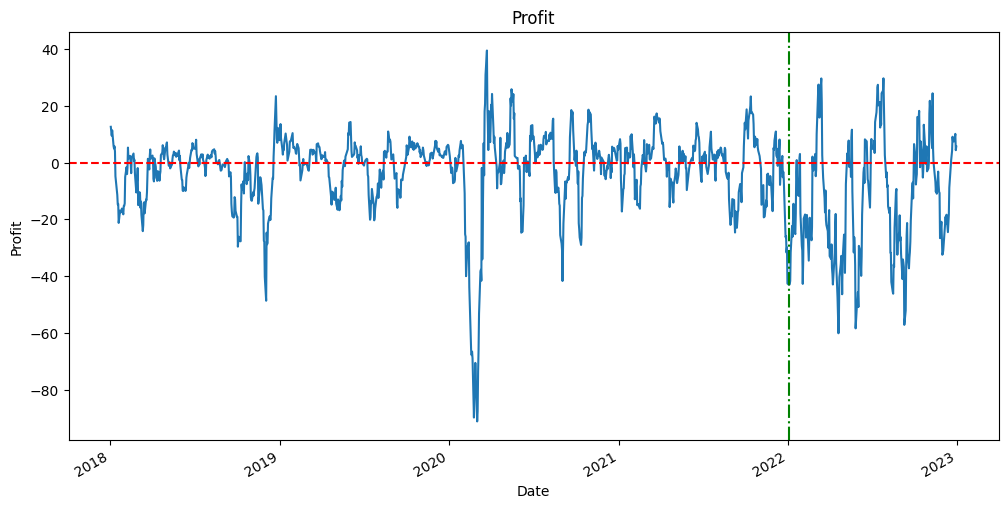

In [72]:
target_df["exp_profit"].plot(figsize=(12,6), xlabel="Date", ylabel="Profit", title="Profit")
plt.axhline(0,ls="--", c="r")
plt.axvline((target_df.index[-len(X_test)]), c="g", ls="-.")
plt.show()

In [88]:
ml_df.loc["2022-12-30","EXPIRE_DATE"]

'2023-01-20'

## Strategy based on Random Forest predictions (out-of-sample)

### Buy or Sell strategy

In [174]:
strategy = []
date_idx = []
for x,i in enumerate(range(len(predictions),0,-1)):
    row = new_df.iloc[-i,:].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    final_price = spy.loc[exp_date,"Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [175]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [176]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2022-01-03,0,478.0,4.81,10.248337,2022-01-24,439.839996,-33.350004,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,-33.360004,-4.800000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.140000,-8.140000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000
2022-01-07,1,466.0,7.56,9.927762,2022-01-28,441.950012,-7.560000,-7.560000
...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,8.453400,2023-01-13,398.500000,8.000000,7.500000
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,7.540000,7.540000
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005


In [177]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

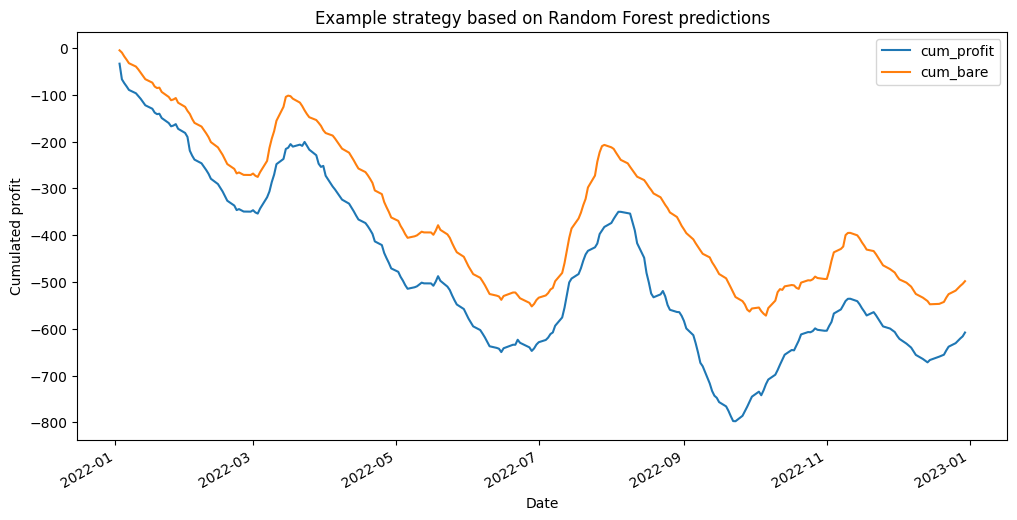

In [178]:
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on Random Forest predictions")
plt.legend()
plt.show()

### Buy only strategy

In [ ]:
strategy = []
date_idx = []
for x,i in enumerate(range(len(predictions),0,-1)):
    row = new_df.iloc[-i,:].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    final_price = spy.loc[exp_date,"Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:    
        res = {"strategy":predictions[x], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [ ]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2022-01-03,0,478.0,4.81,10.248337,2022-01-24,439.839996,0.000000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.140000,-8.140000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000
2022-01-07,1,466.0,7.56,9.927762,2022-01-28,441.950012,-7.560000,-7.560000
...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,8.453400,2023-01-13,398.500000,0.000000,7.500000
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,7.540000,7.540000
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005


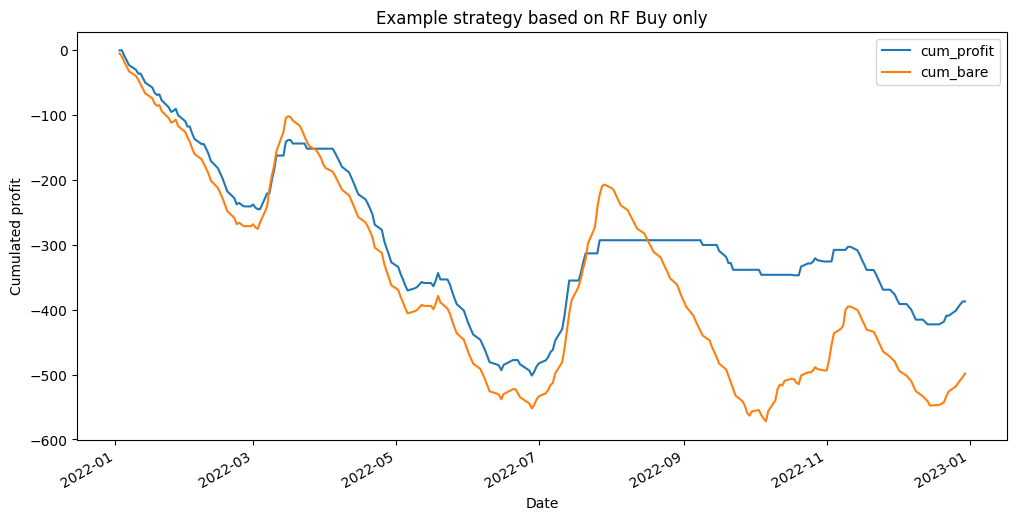

In [ ]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only")
plt.legend()
plt.show()

## Basic strategy (No ML)

### Buy only (whole dataset)

In [199]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(new_df)):
    row = new_df.iloc[i,:].to_dict()
    quote_date = new_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
     # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price

    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    exp_call_price = row["exp_call_price"]
    if exp_call_price< call_price: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":1, 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":0, 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [194]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [200]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2022-01-03,0,478.0,4.81,10.248337,2022-01-24,439.839996,0.000000,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000,0.000000,-9.610000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,0.000000,-8.140000,0.000000,-17.750000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,0.000000,-7.000000,0.000000,-24.750000
2022-01-07,1,466.0,7.56,9.927762,2022-01-28,441.950012,0.000000,-7.560000,0.000000,-32.310000
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,8.453400,2023-01-13,398.500000,0.000000,7.500000,5.270031,-525.980022
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,0.000000,7.540000,5.270031,-518.440022
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005,15.400035,-508.310017


In [201]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

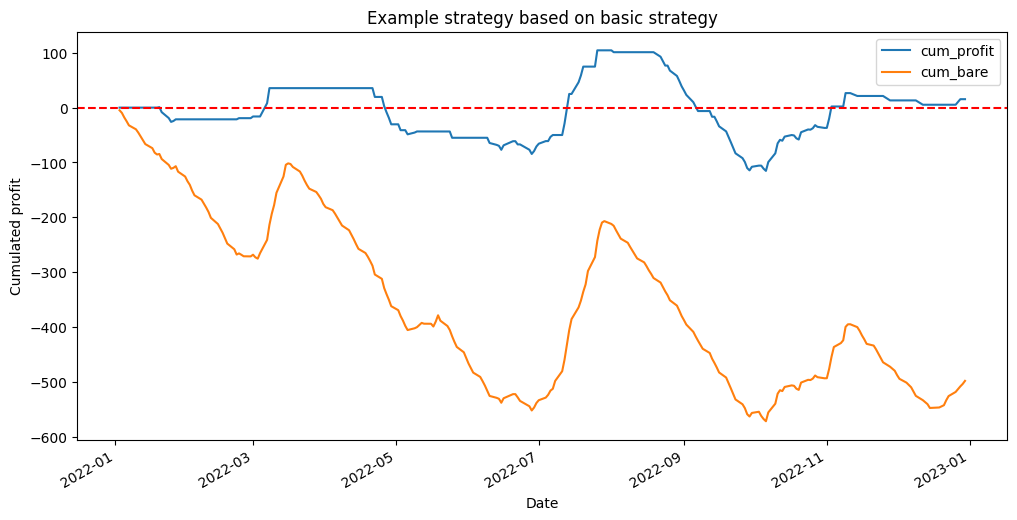

In [203]:
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on basic strategy")
plt.axhline(0,ls="--", c="r")
plt.legend()
plt.show()

## Test in sample 

### Random Forest Buy and Sell

In [166]:
insample_preds = pipe.predict(X_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  73 out of  73 | elapsed:    0.0s finished


In [171]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(insample_preds)):
    row = new_df.iloc[i,:].to_dict()
    quote_date = new_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if insample_preds[i]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [172]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2018-01-02,1,269.0,1.56,4.795895,2018-01-24,283.179993,12.619993,12.619993
2018-01-03,1,270.0,2.15,4.898009,2018-01-24,283.179993,11.029993,11.029993
2018-01-04,1,272.0,1.67,4.327332,2018-01-24,283.179993,9.509993,9.509993
2018-01-05,1,273.0,2.21,4.899561,2018-01-26,286.579987,11.369987,11.369987
2018-01-08,1,274.0,2.08,4.865014,2018-01-31,281.899994,5.819994,5.819994
...,...,...,...,...,...,...,...,...
2021-12-27,0,477.0,5.76,11.573253,2022-01-18,456.489990,-14.750010,-5.760000
2021-12-28,0,477.0,5.29,11.027398,2022-01-18,456.489990,-15.220010,-5.290000
2021-12-29,0,478.0,5.43,10.748298,2022-01-19,451.750000,-20.820000,-5.430000


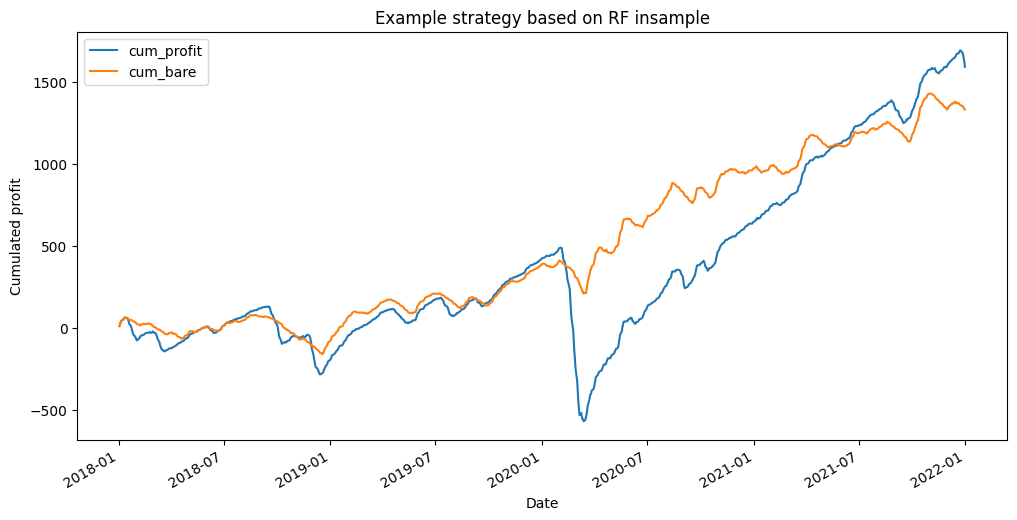

In [173]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF in-sample")
plt.legend()
plt.show()

### Random forest buy only

In [190]:
strategy = []
date_idx = []
prev_price = 0.0
for i in range(len(insample_preds)):
    row = new_df.iloc[i,:].to_dict()
    quote_date = new_df.index[i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date,"EXPIRE_DATE"])
    # Get price at expiration
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if insample_preds[i]: # buy
        if final_price > strike:
            profit = final_price-(strike+call_price)
        else:
            profit = -call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": profit,
               "bare": max(final_price-(strike+call_price), -call_price)}
    else:
        if final_price > strike:
            profit = call_price
        else:
            profit = final_price-strike+call_price
        res = {"strategy":insample_preds[i], 
               "strike":strike,
               "call_price":row["C_LAST"], 
               "exp_call":row["exp_call_price"],
               "exp_date":ml_df.loc[quote_date,"EXPIRE_DATE"],
               "final_price":final_price,
               "profit": 0.0,
               "bare": max(final_price-(strike+call_price), -call_price)}
    strategy.append(res)
    date_idx.append(quote_date)
        
    


In [191]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))
strategy_df


,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare
Date,,,,,,,,
2018-01-02,1,269.0,1.56,4.795895,2018-01-24,283.179993,12.619993,12.619993
2018-01-03,1,270.0,2.15,4.898009,2018-01-24,283.179993,11.029993,11.029993
2018-01-04,1,272.0,1.67,4.327332,2018-01-24,283.179993,9.509993,9.509993
2018-01-05,1,273.0,2.21,4.899561,2018-01-26,286.579987,11.369987,11.369987
2018-01-08,1,274.0,2.08,4.865014,2018-01-31,281.899994,5.819994,5.819994
...,...,...,...,...,...,...,...,...
2021-12-27,0,477.0,5.76,11.573253,2022-01-18,456.489990,0.000000,-5.760000
2021-12-28,0,477.0,5.29,11.027398,2022-01-18,456.489990,0.000000,-5.290000
2021-12-29,0,478.0,5.43,10.748298,2022-01-19,451.750000,0.000000,-5.430000


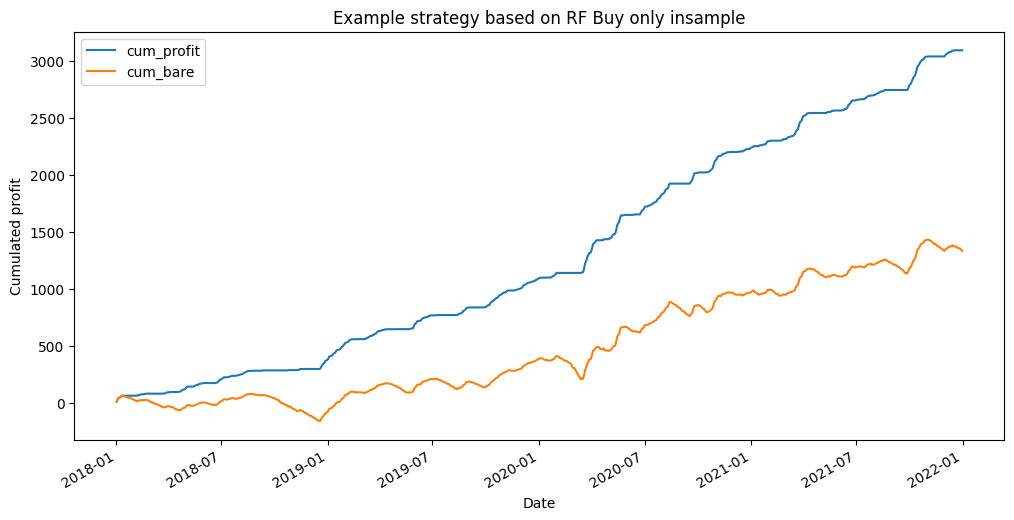

In [192]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)
strategy_df[["cum_profit", "cum_bare"]].plot(figsize=(12,6), ylabel="Cumulated profit", title="Example strategy based on RF Buy only in-sample")
plt.legend()
plt.show()